In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from statistics import mode
from plotly.offline import init_notebook_mode, iplot
from tqdm import tqdm_notebook
from datetime import date, timedelta, datetime
from statsmodels.stats.proportion import proportions_ztest
plt.style.use('fivethirtyeight') 
%matplotlib inline 
pd.options.mode.chained_assignment = None
init_notebook_mode(connected=True)

In [2]:
Data_raw = pd.read_csv('transactions_dataset.csv')
Data = Data_raw.copy()

In [3]:
Data.sample(5)

,order_id,customer_id,order_date,is_canceled,customer_order_number
5046,5046,19997,2016-03-20 05:36:53,0,3
12647,12647,18062,2016-05-23 23:12:42,0,58
7660,7660,81347,2016-04-15 18:41:39,0,1
15482,15482,41343,2016-06-23 02:47:48,0,124
2745,2745,59351,2016-02-18 15:27:42,0,3


In [4]:
Data.shape

(16054, 5)

In [5]:
Data.dtypes

order_id                  int64
customer_id               int64
order_date               object
is_canceled               int64
customer_order_number     int64
dtype: object

In [6]:
Data.isnull().sum()
#no missing values

order_id                 0
customer_id              0
order_date               0
is_canceled              0
customer_order_number    0
dtype: int64

In [7]:
Data['order_date'] = Data['order_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
Data['customer_id'] = Data['customer_id'].astype(str)
Data['order_id'] = Data['order_id'].astype(str)

In [8]:
print('Date ranges from ' + str(Data.order_date.min().date()) + ' to ' + str(Data.order_date.max().date()))

Date ranges from 2016-01-01 to 2016-06-30


In [9]:
Data.dtypes

order_id                         object
customer_id                      object
order_date               datetime64[ns]
is_canceled                       int64
customer_order_number             int64
dtype: object

## Task 1. Investigate transactions time series:

* calculate average orders number placed per hour, day, week

* plot placed orders time series (hourly, daily, weekly bin size) – placed orders count time dependance.

* investigate seasonality: daily, weekly - any hypothesis/conclusions (?)

In [10]:
def orders_by_time(period, period_str):
    """
    Function orders_by_time shows the amount of orders by specific period of time (in table and plot formats).
    
    Input:
    period - period you want to group your data by (in format: Data.order_date.dt.X, X is (hour/day/year))
    period_str - string of selected period (e.g. 'Hour', 'Day', 'Year')
    Call example: mean_by_time(period=Data.order_date.dt.hour, period_str='Hour)
    
    Output:
    1 - table with mean value of orders numbers by specific period
    2 - plot with mean value of orders numbers by specific period
    """
    Temp = []
    Temp = Data.groupby(period)[['customer_order_number']].count()
    Temp.columns = ['Orders']
    Temp.index.name = period_str
    display(Temp)
    
    plt.figure(figsize=(12,5))
    plt.plot(Temp.index, 'Orders', data=Temp, color='green', marker = ".", linewidth=1)
    plt.xlabel(period_str, fontsize=10)
    plt.ylabel('Orders', fontsize=10)
    plt.title(str('Orders by ' + period_str), loc='Center', fontsize=14)
    plt.show()

,Orders
Hour,
0,868
1,987
2,1045
3,913
4,808
5,643
6,410
7,308
8,279


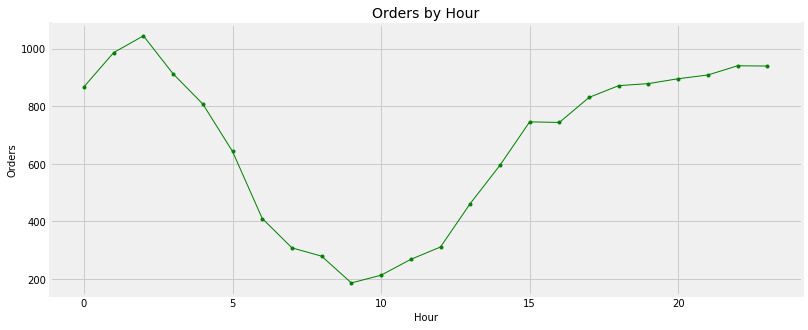

In [11]:
orders_by_time(period=Data.order_date.dt.hour, period_str='Hour')

,Orders
"Weekday (0= Monday, 6=Sunday)",
0,2570
1,2678
2,2572
3,2392
4,2036
5,1787
6,2019


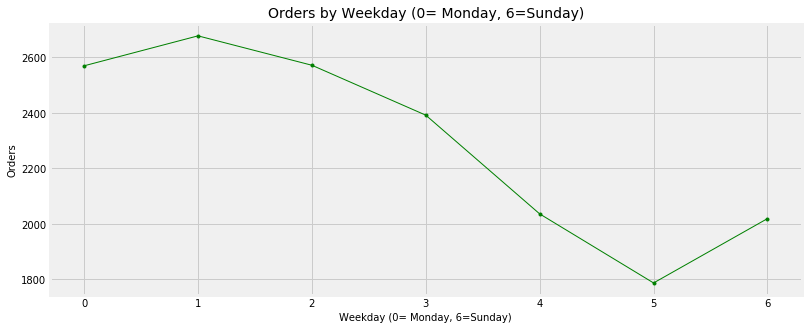

In [12]:
orders_by_time(period=Data.order_date.dt.weekday, period_str='Weekday (0= Monday, 6=Sunday)')

,Orders
Week,
1,264
2,295
3,440
4,421
5,499
6,472
7,545
8,557
9,486


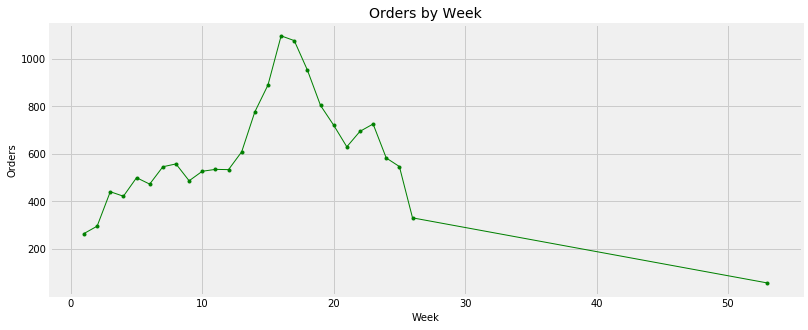

In [13]:
orders_by_time(period=Data.order_date.dt.weekofyear, period_str='Week')

**Note: couple of days in January 2016 are considered as week number 53 since they belong to end of the week in December 2015. First week of 2016 starts with 4th January. Redo without this week:**

,Orders
Week,
1.0,264
2.0,295
3.0,440
4.0,421
5.0,499
6.0,472
7.0,545
8.0,557
9.0,486


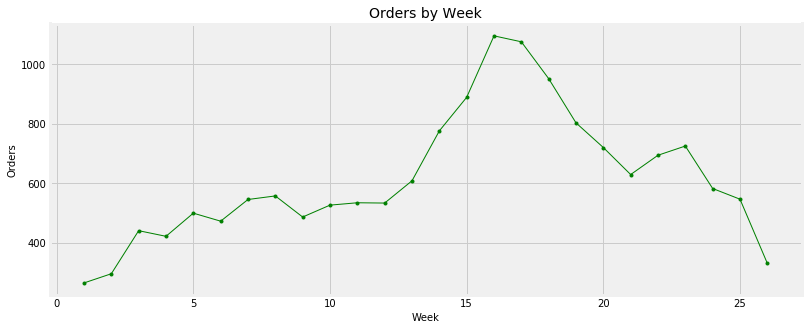

In [14]:
orders_by_time(period=Data.order_date.dt.week[Data.order_date.dt.week != Data.order_date.dt.week.max()],
               period_str='Week')

**Peak periods are:**

* Hourly: 17:00 - 4:00

* Daily: Monday-Wednesday

* Weekly: 15-18 weeks of the year (April - May)

## Task 2. Investigate cancel_rate: % of orders which were canceled

* calculate cancel_rate for the whole dataset

* investigate cancel_rate vs customer_order_number (order number for customer, altering in [1:5] range)

* compare cancel_rate for different months

In [15]:
print('Cancel rate for the whole data set: %.4f' %(sum(Data.is_canceled)/len(Data.is_canceled)))

Cancel rate for the whole data set: 0.0710


In [16]:
#adding new features: min and max order numbers
Temp = Data.groupby(Data.customer_id)[['customer_id', 'customer_order_number']].min()
Temp = Temp.rename(columns={"customer_order_number": "min_order_number"})
Data = pd.merge(Data, Temp, how='left', on='customer_id')

Temp = Data.groupby(Data.customer_id)[['customer_id', 'customer_order_number']].max()
Temp = Temp.rename(columns={"customer_order_number": "max_order_number"})
Data = pd.merge(Data, Temp, how='left', on='customer_id')

Data.head(3)

,order_id,customer_id,order_date,is_canceled,customer_order_number,min_order_number,max_order_number
0,0,52285,2016-01-01 00:09:51,0,2,2,2
1,1,58296,2016-01-01 14:36:14,0,1,1,4
2,2,30609,2016-01-01 14:47:46,0,3,3,3


### Cancel rate vs Customer Order Number

In [17]:
#select only those who have completed from 1 to 5 transactions
Data_cancel = Data[(Data.max_order_number <= 5) & (Data.min_order_number == 1)]

In [18]:
print('Cancel rate for customes with total orders less than 5: %.4f' \
      %(sum(Data_cancel.is_canceled)/len(Data_cancel.is_canceled)))

Cancel rate for customes with total orders less than 5: 0.1023


Text(0.5,1,'Canceled Ratio by Order Number')

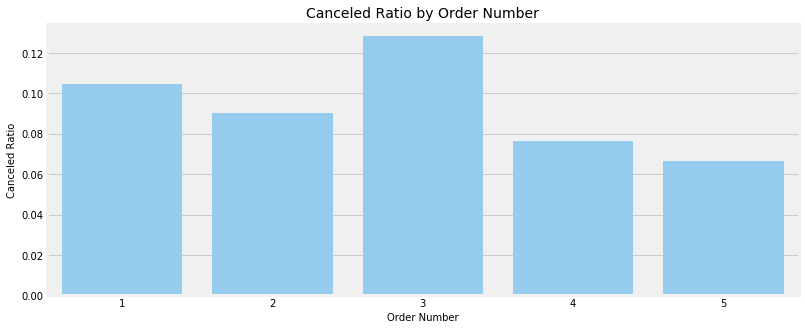

In [19]:
#plot the mean value of returns by max order number
Data_cancel = Data_cancel.groupby(Data_cancel.customer_order_number)[['is_canceled']].sum() / \
Data_cancel.groupby(Data_cancel.customer_order_number)[['is_canceled']].count()

plt.figure(figsize=(12,5))
sns.barplot(Data_cancel.index, 'is_canceled', data=Data_cancel, color='lightskyblue')
plt.xlabel('Order Number', fontsize=10)
plt.ylabel('Canceled Ratio', fontsize=10)
plt.title('Canceled Ratio by Order Number', loc='Center', fontsize=14)

In [20]:
Temp = Data.groupby(Data.customer_order_number)[['is_canceled']].sum() / \
Data.groupby(Data.customer_order_number)[['is_canceled']].count()

data = [go.Bar(x=Temp.index,
              y=Temp.is_canceled, 
              orientation='v')]
layout = go.Layout(
    title='Canceled Ratio by Order Number (whole data set)',
    xaxis=dict(title='Order Number'),
    yaxis=dict(title='Canceled Ratio')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

**It doesn't seem like there is a connection between the number of order and the return ratio. Both new and returned customers trend to make returns (even after 50th+ transaction).**

### Cancel Rate for different months

Text(0.5,1,'Cancel Ratio by Month')

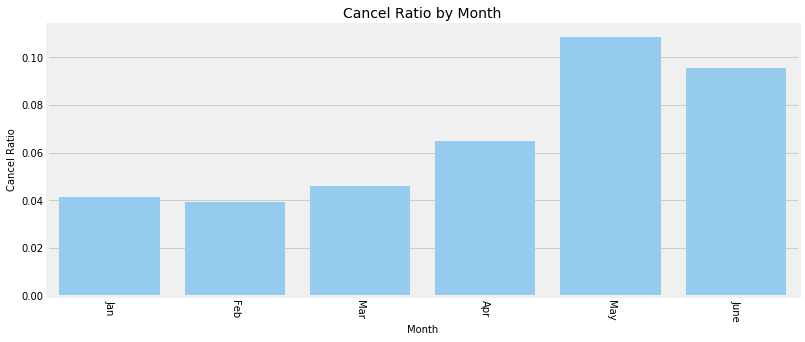

In [21]:
Temp = Data.groupby(Data.order_date.dt.month)[['is_canceled']].sum() / \
Data.groupby(Data.order_date.dt.month)[['is_canceled']].count()

plt.figure(figsize=(12,5))
sns.barplot(Temp.index, 'is_canceled', data=Temp, color='lightskyblue')
plt.xlabel('Month', fontsize=10)
plt.xticks(np.arange(6), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June'], rotation=270)
plt.ylabel('Cancel Ratio', fontsize=10)
plt.title('Cancel Ratio by Month', loc='Center', fontsize=14)

**End of Spring - beginning of Summer seems to be high season for orders cancellation. Can it be caused by summer-specific products?**

## Task 3. Investigate time between customer's placed orders – dT (how often does customer place orders)

* Plot dT histogram, calculate dT mean & percentiles (time after which q={10, 20, ... 90} % of customers have returned

* Compare FCO (1st customer’s order) vs not FCO (2nd customer’s order and more)

* Investigate how many customers place ‘multi-orders’. dT_multi - time between orders is short enough to consider two orders to be placed simultaneously. What dT_multi would would you choose and why?


In [22]:
#sort the data set 
Data = Data.sort_values(by=['customer_id', 'order_date'])
Data = Data.reset_index(drop=True)
Data.head()

,order_id,customer_id,order_date,is_canceled,customer_order_number,min_order_number,max_order_number
0,10741,10001,2016-05-06 01:10:12,0,7,7,8
1,12932,10001,2016-05-26 20:22:29,0,8,7,8
2,8899,100035,2016-04-24 04:24:18,0,1,1,1
3,10254,100036,2016-05-02 23:50:23,0,1,1,2
4,10260,100036,2016-05-03 00:17:16,0,2,1,2


In [23]:
Data['time_delta'] = 0
for i in tqdm_notebook(range(len(Data.order_id) - 1)):
    Data.time_delta[i] = (Data.order_date[i+1].date() - Data.order_date[i].date()).days

A Jupyter Widget

In [24]:
#remove the row with the last order since time delta for that order will be substracted from next customer_id order date
Data_no_max = Data[Data.customer_order_number != Data.max_order_number]

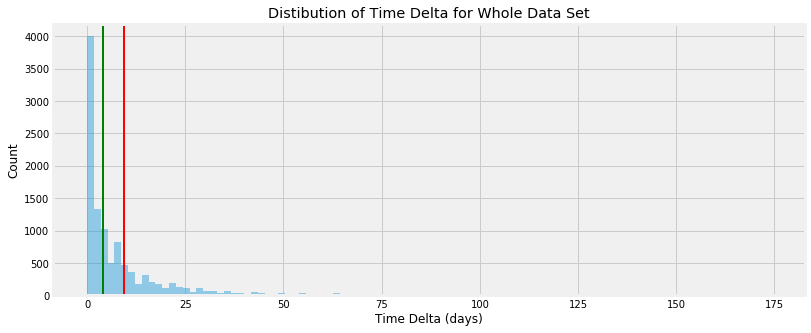

In [25]:
plt.figure(figsize=(12,5))
sns.distplot(Data_no_max.time_delta, kde=False, bins=100)
#red line - average
plt.axvline(x=np.mean(Data_no_max.time_delta), c='r', linewidth=2)
#green line - median
plt.axvline(x=np.median(Data_no_max.time_delta), c='g', linewidth=2)
plt.title('Distibution of Time Delta for Whole Data Set')
plt.xlabel('Time Delta (days)')
plt.ylabel('Count')
plt.show()

In [26]:
print('Average dT over all transactions: %.2f' %(np.mean(Data_no_max.time_delta)))
print('Median of dT over all transactions: %.f' %(np.median(Data_no_max.time_delta)))
print('Mode of dT over all transactions: %.f' %(mode(Data_no_max.time_delta)))

Average dT over all transactions: 9.36
Median of dT over all transactions: 4
Mode of dT over all transactions: 0


In [27]:
for i in np.arange(0.1, 1.1, 0.1):
    print(str(int(i*100)) + '% of transactions have been made within next ' + str(int(Data_no_max.time_delta.quantile(i))) + ' day(s)')

10% of transactions have been made within next 0 day(s)
20% of transactions have been made within next 0 day(s)
30% of transactions have been made within next 1 day(s)
40% of transactions have been made within next 2 day(s)
50% of transactions have been made within next 4 day(s)
60% of transactions have been made within next 6 day(s)
70% of transactions have been made within next 8 day(s)
80% of transactions have been made within next 14 day(s)
90% of transactions have been made within next 25 day(s)
100% of transactions have been made within next 174 day(s)


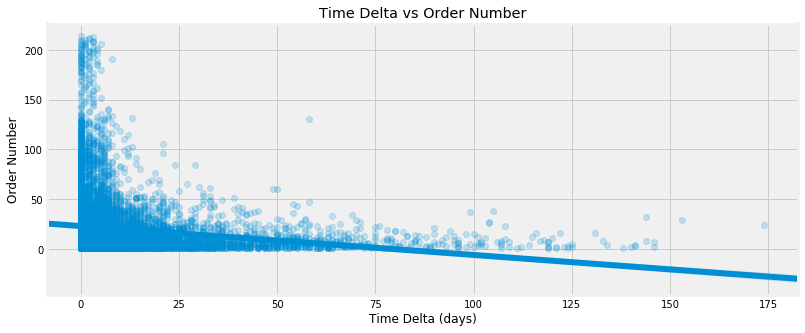

In [28]:
plt.figure(figsize=(12,5))
sns.regplot(x="time_delta", 
            y="customer_order_number", 
            data=Data_no_max, 
            scatter_kws={'alpha':0.2})
plt.title('Time Delta vs Order Number')
plt.xlabel('Time Delta (days)')
plt.ylabel('Order Number')
plt.show()

### Compare FCO vs not FCO

In [29]:
def fco_vs_not_fco(num):
    """
    Function takes number of trasanction to compare time delta with first transaction.
    
    Input:
    num - number of trasanction to compare with
    
    Output:
    1 - plot of distribution ot time deltas over all transactions 
        w/ average value as red line and median as green line
    2 - numeric values for mean and (.25, .5, .75, 1.) quantiles
    """
    Temp = []
    Temp = Data_no_max[Data_no_max.max_order_number >= num] #remove transaction if total number of transaction is less than compared
    Temp = Temp[Temp.min_order_number == 1]
    Temp = Temp[Temp.customer_order_number.isin(range(num))] #keep only rows in a range [1, number - 1]
    Temp = Temp.groupby(Temp.customer_id)[['time_delta']].sum() #get the time delta between 1st and N transaction
    
    #plot the distribution
    plt.figure(figsize=(12,5))
    sns.distplot(Temp.time_delta, kde=False, bins=100)
    #red line - average
    plt.axvline(x=np.mean(Temp.time_delta), c='r', linewidth=2)
    #green line - median
    plt.axvline(x=np.median(Temp.time_delta), c='g', linewidth=2)
    plt.title('Distibution of Time Delta between 1 and ' + str(num) + ' transaction')
    plt.show()
    
    #show numeric values
    print('Average dT between 1 and ' + str(int(num)) + ' transaction: %.2f' %(np.mean(Temp.time_delta)))
    for i in np.arange(0.25, 1.1, 0.25):
        print(str(int(i*100)) + '% of transactions have been made within next ' + str(int(Temp.time_delta.quantile(i))) + ' day(s)')

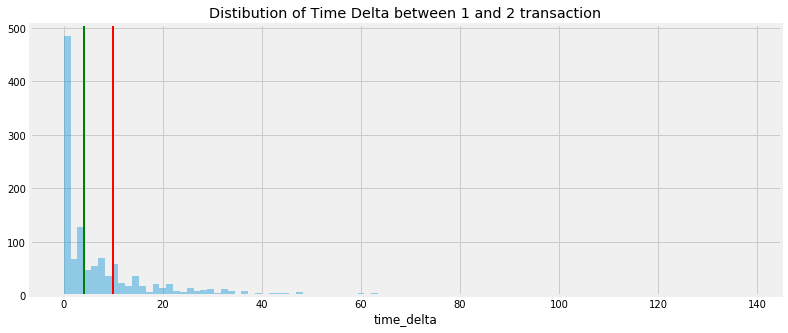

Average dT between 1 and 2 transaction: 9.85
25% of transactions have been made within next 0 day(s)
50% of transactions have been made within next 4 day(s)
75% of transactions have been made within next 12 day(s)
100% of transactions have been made within next 138 day(s)


In [30]:
fco_vs_not_fco(2)

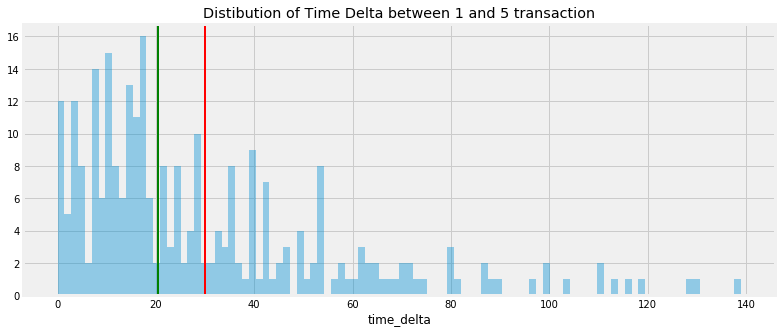

Average dT between 1 and 5 transaction: 30.07
25% of transactions have been made within next 11 day(s)
50% of transactions have been made within next 20 day(s)
75% of transactions have been made within next 42 day(s)
100% of transactions have been made within next 139 day(s)


In [31]:
fco_vs_not_fco(5)

In [32]:
#creat new table which will hold median values for time delta between all orders compared to first
median_over_dt = pd.DataFrame(columns=['interval','days'])
for i in range(2, Data_no_max.max_order_number.max() +1):
    if(Data_no_max.max_order_number.isin([i]).sum() != 0):
        Temp = []
        Temp = Data_no_max[Data_no_max.max_order_number >= i] 
        Temp = Temp[Temp.customer_order_number.isin(range(i))]
        Temp = Temp[Temp.min_order_number == 1]
        Temp = Temp.groupby(Temp.customer_id)[['time_delta']].sum()
        median_over_dt = median_over_dt.append({'interval': str('[1-' + str(i) + ']'), 
                                                'days': np.median(Temp.time_delta)}, 
                                               ignore_index=True)
median_over_dt.head()

/home/ruslan/Soft/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning:

Mean of empty slice.

/home/ruslan/Soft/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning:

invalid value encountered in double_scalars



,interval,days
0,[1-2],4.0
1,[1-3],10.0
2,[1-4],16.0
3,[1-5],20.5
4,[1-6],25.0


In [33]:
median_over_dt = median_over_dt.dropna()

In [34]:
data = [go.Bar(x=median_over_dt.days,
              y=median_over_dt.interval, 
              orientation='h')]
layout = go.Layout(
    title='Median of time delta between intervals',
    xaxis=dict(title='Days between Orders'),
    yaxis=dict(title='Interval between transactions')
)

fig = go.Figure(data=data, layout=layout)
iplot(fig)

**No surprise that the higher number of transaction the more days have been passed from first one.**

### Exploring multi-orders

In [35]:
Data['time_delta_sec'] = 0
for i in tqdm_notebook(range(len(Data.order_id) - 1)):
    Data.time_delta_sec[i] = (Data.order_date[i+1] - Data.order_date[i]).seconds

A Jupyter Widget

In [36]:
Data_sec = Data[Data.customer_order_number != Data.max_order_number]
Data_sec = Data_sec[Data_sec.time_delta == 0]

In [37]:
Data_sec.time_delta_sec = Data_sec.time_delta_sec.apply(lambda x: int(x*0.0166667)) #convert to minutes

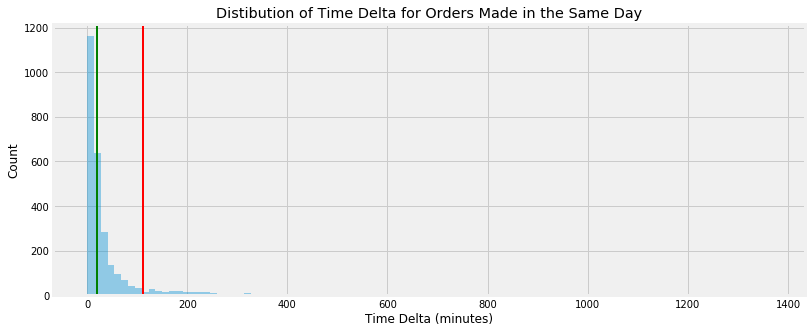

In [38]:
plt.figure(figsize=(12,5))
sns.distplot(Data_sec.time_delta_sec, kde=False, bins=100)
#red line - average
plt.axvline(x=np.mean(Data_sec.time_delta_sec), c='r', linewidth=2)
#green line - median
plt.axvline(x=np.median(Data_sec.time_delta_sec), c='g', linewidth=2)
plt.title('Distibution of Time Delta for Orders Made in the Same Day')
plt.xlabel('Time Delta (minutes)')
plt.ylabel('Count')
plt.show()

In [39]:
print('Average dT over all transactions: %.2f' %(np.mean(Data_sec.time_delta_sec)))
print('Median of dT over all transactions: %.f' %(np.median(Data_sec.time_delta_sec)))
print('Mode of dT over all transactions: %.f' %(mode(Data_sec.time_delta_sec)))

Average dT over all transactions: 112.56
Median of dT over all transactions: 19
Mode of dT over all transactions: 6


**Mode of the distribution of time delta (in minutes) is 6 (median = 19). Mode of the distribution of time delta (in days) is 0. That means that customers don't trend to make next order during the same day as previous order, but during following 6 minutes. We can call say that dT_multi = 6 (orders that were made in 6 minutes after previous order are considered as *'multi-orders'*).**

## Task 4. Investigate customer retention_rate: % of customers who return after completing an order
TIP: probably you would need to assign customer_return_status for each order

1. customer is considered 'returned' if he placed one more order later

2. customer is considered 'lost' if he doesn't return and enough time has passed (dT_loss). What customer lost time period dT_loss would you choose and why?

3. if customer has not returned but not enough time has passed yet (at least according to dataset, where last record=current time) - customer_return_status is considered 'N/A'


* investigate retention_rate vs customer_order_number (altering in [1:5] range, same as with cancel_rate)

* compare customer retention after order was canceled vs successfully finished

In [40]:
print('.95 quantile of time_delta distribution =', int(Data_no_max.time_delta.quantile(.95)))

.95 quantile of time_delta distribution = 40


**95% of customers return after 40 days after previous order was made. Customers who have not made an order after 40 days will be considered as *lost* (~95% probability that they will not come back).**

In [41]:
dT_loss = int(Data_no_max.time_delta.quantile(.95))
thresh_date = Data.order_date.max() - timedelta(days=dT_loss)
print('Threshold date (loss) = ' + str(thresh_date.date()))

Threshold date (loss) = 2016-05-21


In [42]:
Data_status = Data.copy()
Data_status = Data[Data.customer_order_number == Data.max_order_number] #keep just one row for each customer
Data_status = Data_status.reset_index(drop=True)
Data_status['customer_return_status'] = 0 

In [43]:
Data_status.customer_return_status[Data_status.order_date < thresh_date] = 'lost'

In [44]:
print('.9 quantile of time_delta distribution =', int(Data_no_max.time_delta.quantile(.9)))

.9 quantile of time_delta distribution = 25


**90% of customers return after 25 days after previous order was made. Customers with the last order made 25 days ago will be considered as *N/A*.**

In [45]:
dT_na = int(Data_no_max.time_delta.quantile(.9))
thresh_date_na = Data.order_date.max() - timedelta(days=dT_na)
print('Threshold date (N/A) = ' + str(thresh_date_na.date()))

Threshold date (N/A) = 2016-06-05


In [46]:
Data_status.customer_return_status[(Data_status.order_date >= thresh_date) &\
                                  (Data_status.order_date <= thresh_date_na)] = 'N/A'

**All other users (with orders within last 25 days will be considered as *returned*.**

In [47]:
Data_status.customer_return_status[Data_status.order_date > thresh_date_na] = 'returned'

**So in the end status classification looks like this:**

|Day of last order|Status|
|:--|:--|
|(-$\infty$; 40 days ago)|**Lost**|
|[40 days ago; 25 days ago]| **N/A**|
|(25 days ago; Today]|**Returned**|

In [48]:
status_df = pd.DataFrame(Data_status.groupby('customer_return_status')['order_id'].nunique())
status_df.columns = ['amount']

In [49]:
for i in range(len(status_df)):
    print('%.2f' %(status_df.amount[i]*100/status_df.amount.sum()) + '% of customers are ' + status_df.index[i])

10.68% of customers are N/A
69.21% of customers are lost
20.11% of customers are returned


In [50]:
Data = pd.merge(Data, Data_status.loc[:, ['customer_id', 'customer_return_status']], on='customer_id', how='left')

### Retention_rate VS Customer_order_number

*for customers with [1:5] orders range*

In [51]:
Data_filtered = Data_status[(Data_status.min_order_number == 1) & (Data_status.max_order_number <= 5)]
Data_filtered = Data_filtered.groupby(['max_order_number', 'customer_return_status'])[['customer_id']].count()
Data_filtered = Data_filtered.rename(columns={'customer_id': 'amount'})

In [52]:
Temp = Data_filtered.groupby('max_order_number')[['amount']].sum()
Data_filtered = pd.merge(Data_filtered,
                         Temp,
                         left_index= True, right_index= True)
Data_filtered = Data_filtered.rename(columns={'amount_x': 'amount', 'amount_y': 'total_amount'})
Data_filtered['ratio'] = Data_filtered.amount / Data_filtered.total_amount
Data_filtered

amount  total_amount     ratio
max_order_number customer_return_status                                
1                N/A                        275          2362  0.116427
                 lost                      1719          2362  0.727773
                 returned                   368          2362  0.155800
2                N/A                         85           598  0.142140
                 lost                       382           598  0.638796
                 returned                   131           598  0.219064
3                N/A                         43           267  0.161049
                 lost                       151           267  0.565543
                 returned                    73           267  0.273408
4                N/A                         20           134  0.149254
                 lost                        75           134  0.559701
                 returned                    39           134  0.291045
5                N/A                          3            75  0.040000
                 lost                        46            75  0.613333
                 returned                    26            75  0.346667

In [53]:
Data_filtered = Data_filtered.reset_index(level=['max_order_number', 'customer_return_status'])

In [54]:
trace1 = go.Bar(
    x=Data_filtered.max_order_number[Data_filtered.customer_return_status == 'N/A'],
    y=Data_filtered.ratio[Data_filtered.customer_return_status == 'N/A'],
    name='N/A'
)
trace2 = go.Bar(
    x=Data_filtered.max_order_number[Data_filtered.customer_return_status == 'returned'],
    y=Data_filtered.ratio[Data_filtered.customer_return_status == 'returned'],
    name='returned'
)

trace3 = go.Bar(
    x=Data_filtered.max_order_number[Data_filtered.customer_return_status == 'lost'],
    y=Data_filtered.ratio[Data_filtered.customer_return_status == 'lost'],
    name='lost'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='stack',
    title='Customers Status by Max Order Number',
    xaxis={'title': 'Max Order Number'},
    yaxis={'title': 'Ratio'},
)
fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)

### Hypothesis testing

H0 = there is no difference between ratio of lost users by maximum order number

H1 = there is a significant difference

In [55]:
def check_diff(max_number_1, max_number_2, alpha = 0.05):
    """
    Function calculates p-value for two proportions (number of lost customers / total number of customers), 
    compares with significance level (alpha) and prints if we can reject null hypothesis.
    
    Input:
    max_number_1 - Number of maximum of customer_order_number as first test group (1/2/...)
    max_number_2 - Number of maximum of customer_order_number as second test group (1/2/...)
    alpha - significance level. Default level is 0.05 (to be 95% confident)
    
    Output:
    1 - p-value
    2 - ability to reject null hypothesis
    
    """
    lost_1 = Data_filtered.amount[(Data_filtered.max_order_number == max_number_1) & (Data_filtered.customer_return_status == 'lost')]
    total_1 = Data_filtered.total_amount[(Data_filtered.max_order_number == max_number_1) & (Data_filtered.customer_return_status == 'lost')]

    lost_2 = Data_filtered.amount[(Data_filtered.max_order_number == max_number_2) & (Data_filtered.customer_return_status == 'lost')]
    total_2 = Data_filtered.total_amount[(Data_filtered.max_order_number == max_number_2) & (Data_filtered.customer_return_status == 'lost')]
    
    count = np.array([int(lost_1), int(lost_2)]) #lost customers
    nobs = np.array([int(total_1), int(total_2)]) #total number of customers
    stat, pval = proportions_ztest(count, nobs)
    print('Significance level (alpha) = ', alpha)
    print('P-value = %.4f' %(pval))
    if(pval<alpha):
        print('P-value < significance level. Reject null hypothesis (difference is significant).')
    else:
        print('P-value > significance level. Can not reject null hypothesis (difference is not significant).')

In [56]:
check_diff(1, 2)

Significance level (alpha) =  0.05
P-value = 0.0000
P-value < significance level. Reject null hypothesis (difference is significant).


In [57]:
check_diff(2, 3)

Significance level (alpha) =  0.05
P-value = 0.0407
P-value < significance level. Reject null hypothesis (difference is significant).


In [58]:
check_diff(3, 4)

Significance level (alpha) =  0.05
P-value = 0.9114
P-value > significance level. Can not reject null hypothesis (difference is not significant).


In [59]:
check_diff(4, 5)

Significance level (alpha) =  0.05
P-value = 0.4513
P-value > significance level. Can not reject null hypothesis (difference is not significant).


**Seems like customers with who made just one or two orders trend not to make second (third) order in the future.**

### Customer retention after order was canceled vs successfully finished

In [60]:
retention_df = pd.merge(Data_status.groupby('customer_return_status')[['is_canceled']].sum(),
                        Data_status.groupby('customer_return_status')[['is_canceled']].count(),
                        left_index=True, right_index=True,
                        how='left')
retention_df = retention_df.rename(columns={'is_canceled_x': 'canceled_orders', 'is_canceled_y': 'total_orders'})
retention_df['ratio'] = retention_df.canceled_orders / retention_df.total_orders
retention_df

,canceled_orders,total_orders,ratio
customer_return_status,,,
N/A,66,547,0.120658
lost,263,3545,0.074189
returned,89,1030,0.086408


### Check the ratio of two proportions:

H0 = there is no difference between ratio of canceled orders for returned and lost customers

H1 = there is a significant difference

$\alpha$ = 0.05

In [61]:
count = np.array([263, 89]) #canceled_orders
nobs = np.array([3545, 1030]) #total_orders
stat, pval = proportions_ztest(count, nobs)
print('P-value = %.4f' %(pval))

P-value = 0.1952


**P-value > $\alpha$.**

**We cannot reject null hypothesis, so we can not say if people with canceled orders trend to come back or not. **